In [1]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [9]:
iris = datasets.load_iris()
eye = iris.data
eye

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [10]:
def gaussian(eye, mu, cov):
    n = eye.shape[1]
    diff = (eye - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [6]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [11]:
def initialize_clusters(eye, n_clusters):
    clusters = []
    idx = np.arange(eye.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(eye)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(eye.shape[1], dtype=np.float64)
        })
        
    return clusters


In [12]:
def expectation_step(eye, clusters):
    totals = np.zeros((eye.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(eye, mu_k, cov_k)).astype(np.float64)
        
        for i in range(eye.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

In [13]:
def maximization_step(eye, clusters):
    N = float(eye.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((eye.shape[1], eye.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * eye, axis=0) / N_k
        
        for j in range(eye.shape[0]):
            diff = (eye[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [14]:
def get_likelihood(eye, clusters):
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [35]:

def train_gmm(eye, n_clusters, n_epochs):
    clusters = initialize_clusters(eye, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((eye.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(eye, clusters)
        maximization_step(eye, clusters)

        likelihood, sample_likelihoods = get_likelihood(eye, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

In [18]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(eye, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -2183.364297367163
Epoch:  2 Likelihood:  -687.9930619889924
Epoch:  3 Likelihood:  -599.244386338913
Epoch:  4 Likelihood:  -587.2166556096773
Epoch:  5 Likelihood:  -577.1883030702885
Epoch:  6 Likelihood:  -569.9844076794175
Epoch:  7 Likelihood:  -565.1009094779275
Epoch:  8 Likelihood:  -561.3665532118041
Epoch:  9 Likelihood:  -557.9066482188396
Epoch:  10 Likelihood:  -554.7082225664111
Epoch:  11 Likelihood:  -551.8847892480703
Epoch:  12 Likelihood:  -549.3689988283984
Epoch:  13 Likelihood:  -547.2652544807574
Epoch:  14 Likelihood:  -545.5594286930434
Epoch:  15 Likelihood:  -543.8235990782625
Epoch:  16 Likelihood:  -542.0117820714644
Epoch:  17 Likelihood:  -541.0209637151715
Epoch:  18 Likelihood:  -540.6999702580206
Epoch:  19 Likelihood:  -540.6012362811375
Epoch:  20 Likelihood:  -540.5705173574368
Epoch:  21 Likelihood:  -540.560887786417
Epoch:  22 Likelihood:  -540.5578476006328
Epoch:  23 Likelihood:  -540.5568826889845
Epoch:  24 Likelihood:

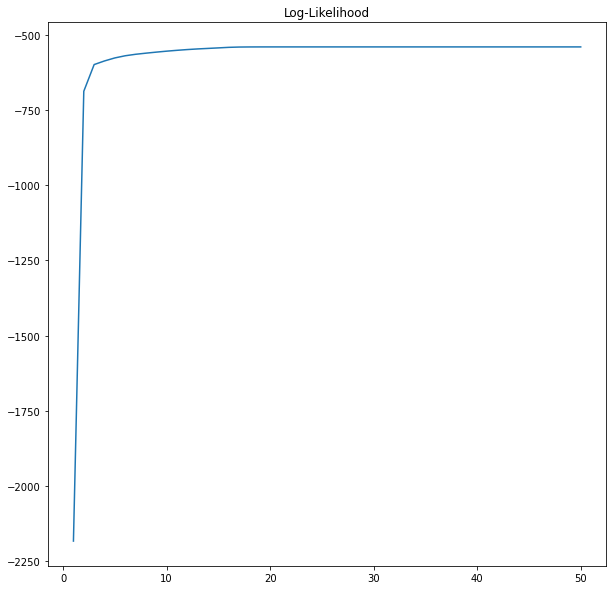

In [19]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

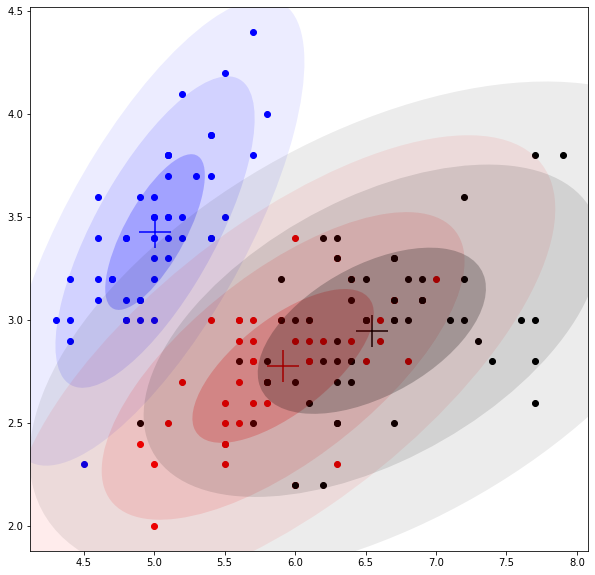

In [21]:
def create_cluster_animation(eye, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(eye.shape[0]):
            ax.scatter(eye[i, 0], eye[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(eye, history, scores)

In [34]:

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters).fit(eye)
gmm_scores = gmm.score_samples(eye)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])


Means by sklearn:
 [[5.006      3.428      1.462      0.246     ]
 [5.91697517 2.77803998 4.20523542 1.29841561]
 [6.54632887 2.94943079 5.4834877  1.98716063]]
Means by our implementation:
 [[5.006      3.428      1.462      0.246     ]
 [5.91496959 2.77784365 4.20155323 1.29696685]
 [6.54454865 2.94866115 5.47955343 1.98460495]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]
